In [ ]:
""" Testing/Debugging File """

"""
Restart kernel after running
Only need to run once
"""
!pip install scikit-learn matplotlib seaborn

In [1]:
""" Configure path to config file and select whether hyperparameter sweeping or not """
config_folder_path = "./configs/"
config_file_name = "cnn_1"
results_folder_path = "./results/"
sweep_config = {
    'method': 'grid'
}

input_data_file = './data/k562_datasets.pkl'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import math 
import json
import torch
import torch.utils.data as td
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset, Subset, BatchSampler

In [3]:
""" Load datasets """
with open(input_data_file, 'rb') as file:
    combined_datasets = pickle.load(file)
    
nucleotides = ['A', 'T', 'G', 'C']

train_data = combined_datasets['train']
valid_data = combined_datasets['valid']
test_data = combined_datasets['test']

print(train_data.iloc[0])

column_names = np.array(train_data.columns)
feature_names = column_names[6:16]
num_features = len(feature_names)
print(feature_names)
num_samples = train_data.shape[0]
num_seq_features = len(nucleotides)

print("Number of Samples: " + str(num_samples))
print("Number of Features: " + str(num_features))

cuda_available = torch.cuda.is_available()
print("CUDA (GPU support) is available:", cuda_available)
num_gpus = torch.cuda.device_count()
print("Number of GPUs available:", num_gpus)

torch.backends.cudnn.benchmark = True

seqnames                         1
start                      1002760
end                        1002760
strand                           +
ensembl_gene_id    ENSG00000187608
score                          0.0
ctcf                      -0.07771
h4k20me1                 -0.429997
h3k79me2                   -0.2804
h3k4me1                  -0.217665
h3k9me3                  -0.333359
h3k36me3                 -0.801406
sj5                      -0.039619
sj3                      -0.059131
rpts                     -0.187111
wgbs                           0.0
lambda_alphaj             0.026377
zeta                      1.133344
A                                0
T                                0
G                                1
C                                0
dataset                      train
Name: 0, dtype: object
['ctcf' 'h4k20me1' 'h3k79me2' 'h3k4me1' 'h3k9me3' 'h3k36me3' 'sj5' 'sj3'
 'rpts' 'wgbs']
Number of Samples: 136927782
Number of Features: 10
CUDA (GPU support) is available

In [4]:
from sklearn.preprocessing import MinMaxScaler

""" Process data using a sliding window approach """
class GeneDataset(Dataset):
    def __init__(self, dataframe, use_sliding_window=False, window_size=100):
        self.dataframe = dataframe
        self.grouped_data = dataframe.groupby('ensembl_gene_id')
        self.use_sliding_window = use_sliding_window
        self.window_size = window_size
        self.cache = {}
        self.windows = []

        # use subsequence windows from genes
        if self.use_sliding_window and window_size is not None:
            self._create_windows()
        # use full-length genes
        else:
            self._prepare_full_genes()
    
    def _create_windows(self):
        for gene_id, group in self.grouped_data:
            gene_length = len(group)
            for start_idx in range(0, gene_length - self.window_size + 1, self.window_size):
                end_idx = start_idx + self.window_size
                if end_idx > gene_length:
                    break
                window = group.iloc[start_idx:end_idx]
                self.windows.append((gene_id, window))
    
    def _prepare_full_genes(self):
        for gene_id, group in self.grouped_data:
            self.windows.append((gene_id, group))

    def __len__(self):
        return len(self.windows)

    # prepare single window or gene
    def __getitem__(self, idx):
        gene_id, window = self.windows[idx]
        
        if gene_id in self.cache:
            return self.cache[gene_id]
        
        strand_encoded = window['strand'].map({'-': 0, '+': 1}).values
        strand_tensor = torch.tensor(strand_encoded, dtype=torch.int64)
 
        result = {
            'GeneId': gene_id,
            'Seq_Name': window['seqnames'].iloc[0],
            'Start': torch.tensor(window['start'].values, dtype=torch.int64),
            'End': torch.tensor(window['end'].values, dtype=torch.int64),
            'Strand': strand_tensor,
            
            # epigenomic features per gene j, site i
            'Y_ji':  torch.tensor(window[feature_names].values, dtype=torch.float64),
            
            # read counts per gene j, site i
            'X_ji': torch.tensor(window['score'].values, dtype=torch.float64),
            
            # read depth * initiation rate values per gene j
            'C_j': torch.tensor(window['lambda_alphaj'].iloc[0], dtype=torch.float64),
            
            # GLM elongation rate predictions per gene j, site i
            'Z_ji': torch.tensor(window['zeta'].values, dtype=torch.float64),
            
            # one-hot encoded sequences
            'N_ji': torch.tensor(window[nucleotides].values, dtype=torch.float64), 
            'Length': len(window)
        }
    
        self.cache[gene_id] = result

        return result

In [5]:
""" Batch subsequences with same gene id together """
class GeneIdBatchSampler(BatchSampler):
    def __init__(self, dataset):
        self.dataset = dataset
        self.batches = self._create_batches()

    def _create_batches(self):
        # Group indices by GeneId
        gene_id_to_indices = {}
        for idx in range(len(self.dataset)):
            gene_id = self.dataset[idx]['GeneId']
            if gene_id not in gene_id_to_indices:
                gene_id_to_indices[gene_id] = []
            gene_id_to_indices[gene_id].append(idx)

        return list(gene_id_to_indices.values())

    def __iter__(self):
        for batch in self.batches:
            yield batch

    def __len__(self):
        return len(self.batches)

In [6]:
def build_dataset(data, use_sliding_window, window_size=None):
    dataset = GeneDataset(data, use_sliding_window, window_size)
    batch_sampler = GeneIdBatchSampler(dataset)
    loader = DataLoader(dataset, batch_sampler=batch_sampler, shuffle=False, num_workers=7)
    return loader

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def build_model(config):

    class EpLinearModel(nn.Module):
        def __init__(self, input_size):
            super(EpLinearModel, self).__init__()
            self.name = "ep_linear"
            self.linear = nn.Linear(input_size, 1)

        def forward(self, Y_ji):
            x = self.linear(Y_ji)
            return x.squeeze(-1)   
    
    class EpSeqLinearModel(nn.Module):
        def __init__(self, num_ep_features, num_seq_features):
            super(EpSeqLinearModel, self).__init__()
            self.name = "ep_seq_linear"
            self.y_linear = nn.Linear(num_ep_features, 1)
            self.n_linear = nn.Linear(num_seq_features, 1)
            self.final_linear = nn.Linear(2, 1)

        def forward(self, Y_ji, N_ji):
            y = self.y_linear(Y_ji)
            n = self.n_linear(N_ji)
            x = torch.cat((y, n), axis=-1)
            x = self.final_linear(x)
            return x.squeeze(-1)
    
    class LSTMModel(nn.Module):
        def __init__(self, input_size, layer_size, num_layers, bidirectional):
            super(LSTMModel, self).__init__()
            self.name = "lstm"
            self.lstm = nn.LSTM(input_size, layer_size, num_layers, bidirectional=bidirectional, batch_first=True)
            self.bidirectional_linear = nn.Linear(2 * layer_size, 1)
            self.linear = nn.Linear(layer_size, 1)
            self.bidirectional = bidirectional

        def forward(self, Y_ji, N_ji):
            x = torch.cat((Y_ji, N_ji), axis=-1)
            x, _ = self.lstm(x)
            if self.bidirectional:
                x = self.bidirectional_linear(x)
            else:
                x = self.linear(x)
            return x.squeeze(-1)
        
    class CNN(nn.Module):
        def __init__(self, num_ep_features, num_seq_features, 
                     y_channels, y_kernel_sizes,
                     n_channels, n_kernel_sizes, dropout, 
                     lstm_layer_size, num_lstm_layers=None, bidirectional=False):
            
            super(CNN, self).__init__()
            self.name = "cnn"            

            self.y_convs = nn.ModuleList()
            y_in_channels = num_ep_features
            
            if len(y_kernel_sizes) != len(y_channels):
                raise InvalidConfigurationError("Y_ji channels and Y_ji kernels lists must have matching lengths")
            
            # Y_ji convolutional layers
            for idx, out_channels in enumerate(y_channels):
                self.y_convs.append(
                    nn.Conv1d(y_in_channels, out_channels, y_kernel_sizes[idx], stride=1, padding='same')
                )
                y_in_channels = out_channels
            
            
            self.n_convs = nn.ModuleList()
            n_in_channels = num_seq_features
            
            if len(n_kernel_sizes) != len(n_channels):
                raise InvalidConfigurationError("N_ji channels and N_ji kernels lists must have matching lengths")

            for idx, out_channels in enumerate(n_channels):
                self.n_convs.append(
                    nn.Conv1d(n_in_channels, out_channels, n_kernel_sizes[idx], stride=1, padding='same')
                )
                n_in_channels = out_channels

            self.relu = nn.ReLU()
            self.dropout = nn.Dropout(dropout)

            # Final convolutional layer to map to a single output channel
            # Since the output needs to be (batch_size, seq_len), we map the final features to 1
            self.final_conv = nn.Conv1d(y_channels[-1] + n_channels[-1], 1, 1)  # 1x1 convolution
            
            self.num_lstm_layers = num_lstm_layers
            if num_lstm_layers != 0 and num_lstm_layers != None:
                self.gru = nn.GRU(input_size=y_channels[-1] + n_channels[-1], hidden_size=lstm_layer_size, num_layers=num_lstm_layers, bidirectional=bidirectional, batch_first=True)
            
            self.final_linear = nn.Linear(lstm_layer_size, 1)
            self.bidirectional = True
            self.final_bidirectional_linear = nn.Linear(lstm_layer_size*2, 1)
            #self.batch_norm = nn.BatchNorm1d(y_hidden_layer_sizes[-1] + n_hidden_layer_sizes[-1])
            
        def forward(self, Y_ji, N_ji):
            Y_ji = Y_ji.permute(0, 2, 1)  
            N_ji = N_ji.permute(0, 2, 1)
            
            for conv in self.y_convs:
                Y_ji = conv(Y_ji)
                Y_ji = self.relu(Y_ji)
                Y_ji = self.dropout(Y_ji)
            
            for conv in self.n_convs:
                N_ji = conv(N_ji)
                N_ji = self.relu(N_ji)
                N_ji = self.dropout(N_ji)

            x = torch.cat((Y_ji, N_ji), 1)
            
            #x = self.batch_norm(x)
            
            if self.num_lstm_layers != 0 and self.num_lstm_layers != None:
                x = x.permute(0,2,1)
                x, (h_n, c_n) = self.gru(x)
                if self.bidirectional:
                    x = self.final_bidirectional_linear(x)
                else:
                    x = self.final_linear(x)
                x = x.squeeze(-1)
            
            else:
                x = self.final_conv(x)
                x = x.squeeze(1)  
                
            return x
    
    if config["model_type"] == 'lstm':
        model = LSTMModel(num_features + num_seq_features, config["lstm_layer_size"], config["num_lstm_layers"], config["bidirectional"])
    elif config["model_type"] == 'ep_seq_linear':
        model = EpSeqLinearModel(num_features, num_seq_features)
    elif config["model_type"] == 'ep_linear':
        model = EpLinearModel(num_features)
    elif config["model_type"] == 'cnn':
        lstm_layer_size = None
        bidirectional = None
        if config["num_lstm_layers"] != 0 and config["num_lstm_layers"] != None:
            lstm_layer_size = config["lstm_layer_size"]
            bidirectional = config["bidirectional"]
        model = CNN(num_features, num_seq_features, config["y_channels"], config["y_kernel_sizes"], 
                    config["n_channels"], config["n_kernel_sizes"], config["dropout"], 
                    config["num_lstm_layers"], lstm_layer_size, bidirectional)
    
    if cuda_available:
        if num_gpus > 1:
            print("Using", num_gpus, "GPUs")
            model = torch.nn.DataParallel(model)
        model = model.to('cuda')

    print(model)

    
    model.double()

    return model.to(device)

In [8]:
def build_optimizer(network, learning_rate, l2_lambda):
    optimizer = optim.Adam(network.parameters(), lr=learning_rate, weight_decay=l2_lambda)
    return optimizer

In [9]:
def valid_epoch(model, loader, loss_fn):
    model.eval()
    total_neural_net_loss = 0
    total_glm_loss = 0
    neural_net_zeta = []
    glm_zeta = []
    
    with torch.no_grad():
        for idx, batch in enumerate(loader):
            Y_ji_batch = batch['Y_ji'].to(device)
            X_ji_batch = batch['X_ji'].to(device)
            N_ji_batch = batch['N_ji'].to(device) 
            C_j_batch = batch['C_j'].to(device).unsqueeze(1)
            Z_ji_batch = batch['Z_ji'].to(device)
            
            if model.name == "ep_linear":
                outputs = model(Y_ji_batch)
            else:
                outputs = model(Y_ji_batch, N_ji_batch)
                
            neural_net_loss = loss_fn(X_ji_batch, C_j_batch, outputs)
            glm_loss = loss_fn(X_ji_batch, C_j_batch, torch.log(Z_ji_batch))

            total_neural_net_loss +=  neural_net_loss.item()
            total_glm_loss += glm_loss.item()
            
            # store all predictions in list
            neural_net_zeta.append(torch.exp(outputs.cpu().flatten()))
            glm_zeta.append(batch['Z_ji'].flatten())
    
    # calculate average loss across all batches
    avg_neural_net_loss = total_neural_net_loss / len(loader)
    avg_glm_loss = total_glm_loss / len(loader)
    
    neural_net_zeta = torch.cat(neural_net_zeta)
    glm_zeta = torch.cat(glm_zeta)
    
    return avg_neural_net_loss, avg_glm_loss, neural_net_zeta, glm_zeta

In [10]:
def train_epoch(model, loader, optimizer, loss_fn, l1_lambda):
    model.train()
    total_loss = 0
    for idx, batch in enumerate(loader):
        optimizer.zero_grad(set_to_none=True)
        Y_ji_batch = batch['Y_ji'].to(device) 
        X_ji_batch = batch['X_ji'].to(device)
        N_ji_batch = batch['N_ji'].to(device) 
        C_j_batch = batch['C_j'].to(device).unsqueeze(1)
        
        if model.name == "ep_linear":
            outputs = model(Y_ji_batch)
        else:
            outputs = model(Y_ji_batch, N_ji_batch)
        
        loss = loss_fn(X_ji_batch, C_j_batch, outputs)
        
        if l1_lambda != 0:
            l1_norm = sum(torch.abs(p).sum() for p in model.parameters())
            loss = loss + l1_lambda * l1_norm
        
        loss.backward()
        optimizer.step()
        
        # calculate average loss across all batches
        total_loss += loss.item()
    avg_train_loss = total_loss / len(loader)
    
    return avg_train_loss

In [11]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, X_ji, C_j, rho_ji):
        loss = X_ji * rho_ji + C_j * torch.exp(-rho_ji) - X_ji * torch.log(C_j)
        
        # calculate average loss within each batch
        return (loss).mean()

In [12]:
with open(config_folder_path + config_file_name + ".json", 'r') as file:
    config = json.load(file)

In [13]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
increase_cut=0.00001
patience=5

def train():
    model = build_model(config)
    
    train_window_size = None
    if config["train_use_sliding_window"]:
        train_window_size = config["train_window_size"]
    train_loader = build_dataset(train_data, config["train_use_sliding_window"], train_window_size)
    
    valid_window_size = None
    if config["valid_use_sliding_window"]:
        valid_window_size = config["valid_window_size"]
    valid_loader = build_dataset(valid_data, config["valid_use_sliding_window"], valid_window_size)
    
    optimizer = build_optimizer(model, config['learning_rate'], config['l2_lambda'])
    
    loss_fn = torch.jit.script(CustomLoss())
    # track loss curves
    loss_neural_net_train = [0] * config["epochs"]
    loss_neural_net_valid = [0] * config["epochs"]
    loss_glm_valid = [0] * config["epochs"]
    
    # scheduler to reduce learning rate by half when new validation loss > old validation loss
    old_neural_net_valid_loss = float('inf')
    epochs_no_improve = 0
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1, verbose=True)

    for epoch in range(config["epochs"]):
        print(f'Epoch {epoch+1}')
        
        train_loss = train_epoch(model, train_loader, optimizer, loss_fn, config['l1_lambda'])
        loss_neural_net_train[epoch] = train_loss
        print(f"train loss: {train_loss: .5f}")
        
        valid_neural_net_loss, valid_glm_loss, neural_net_zeta, glm_zeta = valid_epoch(model, valid_loader, loss_fn)
        loss_neural_net_valid[epoch] = valid_neural_net_loss
        loss_glm_valid[epoch] = valid_glm_loss
        print(f"valid neural net loss: {valid_neural_net_loss: .5f}")
        print(f"valid glm loss: {valid_glm_loss: .5f}")
        
        # compute metrics
        mae = F.l1_loss(neural_net_zeta.squeeze(), glm_zeta)
        mse = F.mse_loss(neural_net_zeta.squeeze(), glm_zeta)
        correlation_coefficient = np.corrcoef(glm_zeta, neural_net_zeta.squeeze())[0, 1]
        print("Correlation Coefficient:", correlation_coefficient)
        print(f"Mean Absolute Error: {mae.item():.4f}")
        print(f"Mean Squared Error: {mse.item():.4f}")
        
        if config["wandb_logging"]:
            wandb.log({"epoch": epoch, "train_loss": train_loss, "valid_neural_net_loss": valid_neural_net_loss,
           "valid_glm_loss": valid_glm_loss, "correlation_coefficient": correlation_coefficient,
           "mae": mae, "mse": mse})
        
        # early stopping
        if valid_neural_net_loss < old_neural_net_valid_loss - increase_cut:
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            
        if epochs_no_improve == patience:
            print("Early Stopping")
            break
        
        # reduce learning rate if new loss > old loss
        if valid_neural_net_loss > old_neural_net_valid_loss:
            optimizer.param_groups[0]['lr'] *= 0.5
            print(f"Reduced learning rate to {optimizer.param_groups[0]['lr']}")
            
        old_neural_net_valid_loss = valid_neural_net_loss
        scheduler.step(valid_neural_net_loss)
        
    return model, loss_neural_net_train, loss_neural_net_valid, loss_glm_valid

In [14]:
if config["wandb_logging"]:
    metric = {
        'name': 'valid_neural_net_loss',
        'goal': 'minimize'   
    }
    sweep_config['metric'] = metric
    sweep_config['parameters'] = config
    sweep_id = wandb.sweep(sweep_config, project=config_file_name)
    wandb.init(config=config)
    wandb.agent(sweep_id, train)

In [15]:
from datetime import datetime

if config["wandb_logging"] == False:
    model, loss_neural_net_train, loss_neural_net_valid, loss_glm_valid = train()

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"models/{config_file_name}.pth"
    torch.save(model.state_dict(), filename)

/grid/siepel/home_norepl/hassett/.local/lib/python3.7/site-packages/torch/nn/init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


CNN(
  (y_convs): ModuleList(
    (0): Conv1d(10, 16, kernel_size=(9,), stride=(1,), padding=same)
  )
  (n_convs): ModuleList(
    (0): Conv1d(4, 32, kernel_size=(3,), stride=(1,), padding=same)
    (1): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=same)
    (2): Conv1d(64, 128, kernel_size=(9,), stride=(1,), padding=same)
  )
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (final_conv): Conv1d(144, 1, kernel_size=(1,), stride=(1,))
  (final_linear): Linear(in_features=0, out_features=1, bias=True)
  (final_bidirectional_linear): Linear(in_features=0, out_features=1, bias=True)
)
Epoch 1
train loss:  0.13781
valid neural net loss:  0.13904
valid glm loss:  0.14891
Correlation Coefficient: 0.1827971483559709
Mean Absolute Error: 0.5740
Mean Squared Error: 0.5264
Epoch 2
train loss:  0.13470
valid neural net loss:  0.13846
valid glm loss:  0.14891
Correlation Coefficient: 0.21406603099570096
Mean Absolute Error: 0.6116
Mean Squared Error: 0.6382
Epoch 3
train loss

In [16]:
# load model state

model = build_model(config["model_type"], num_features, num_seq_features, 
                    config["y_channels"], config["y_kernel_sizes"],
                    config["n_channels"], config["n_kernel_sizes"], config["dropout"],
                    config["lstm_layer_size"], config["num_lstm_layers"], config["bidirectional"])

model.load_state_dict(torch.load(f"./models/{config_file_name}.pth", map_location=torch.device('cpu')))

cuda_available = torch.cuda.is_available()
print("CUDA (GPU support) is available:", cuda_available)
num_gpus = torch.cuda.device_count()
print("Number of GPUs available:", num_gpus)
if cuda_available:
    if num_gpus > 1:
        print("Using", num_gpus, "GPUs")
        model = torch.nn.DataParallel(model)
    model = model.to('cuda')

first_param_device = next(model.parameters()).device
print("Model is on device:", first_param_device)

model.double()

KeyError: 'sn_channels'

<function matplotlib.pyplot.show(close=None, block=None)>

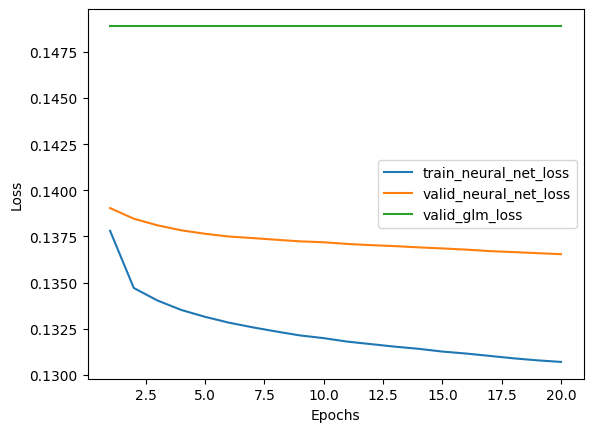

In [17]:
epochs = range(1, len(loss_neural_net_train) + 1)
plt.plot(epochs, loss_neural_net_train, label='train_neural_net_loss')
plt.plot(epochs, loss_neural_net_valid, label='valid_neural_net_loss')
plt.plot(epochs, loss_glm_valid, label='valid_glm_loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig("./results/cnn_1/loss_curves.png")
plt.show 

In [18]:
model.eval()

tstdl = build_dataset(test_data, False, None)
data_iter = iter(tstdl)

In [19]:
def plot_data(glm_zeta, net_zeta, file_name, plot_first_window, window_size):
    if plot_first_window:
        indices = range(window_size)
    else:
        indices = range(len(glm_zeta))
    
    fig, ax = plt.subplots(figsize=(10, 5))
    
    if plot_first_window:
        net_zeta = net_zeta[0:window_size]
        glm_zeta = glm_zeta[0:window_size]
    
    ax.scatter(indices, net_zeta, color='blue', label='Neural Net Zeta', s=10, alpha=0.5)
    ax.scatter(indices, glm_zeta, color='orange', label='GLM Zeta', s=10, alpha=0.5)
    
    ax.set_title('Neural Net vs GLM Elongation Rate')
    ax.set_xlabel('Index')
    ax.set_ylabel('Elongation Rate')
    ax.legend()
    
    plt.ylim(0, 6.5)

    plt.savefig(file_name)
    plt.close()
    
    plt.show()

In [21]:
results_dir = results_folder_path + config_file_name
os.makedirs(results_dir, exist_ok=True)

In [22]:
# compute metrics for test dataset

loss_fn = CustomLoss()

total_net_loss = 0
total_glm_loss = 0
net_zeta = []
glm_zeta = []
with torch.no_grad():
    for batch in tstdl:
        Y_ji = batch['Y_ji'].to(device)
        N_ji = batch['N_ji'].to(device)
        X_ji = batch['X_ji'].to(device)
        C_j = batch['C_j'].to(device).unsqueeze(1)
        Z_ji = batch['Z_ji'].to(device)
        
        if model.name == "ep_linear":
            rho_ji = model(Y_ji)
        else:
            rho_ji = model(Y_ji, N_ji)
        
        net_loss = loss_fn(X_ji, C_j, rho_ji)
        glm_loss = loss_fn(X_ji, C_j, torch.log(Z_ji))
        
        total_net_loss += net_loss.item()
        total_glm_loss += glm_loss.item()
        
        net_zeta.append(torch.exp(rho_ji.cpu()).flatten())
        glm_zeta.append(batch['Z_ji'].flatten())

        
net_zeta = torch.cat(net_zeta)
glm_zeta = torch.cat(glm_zeta)

mae = F.l1_loss(net_zeta, glm_zeta)
mse = F.mse_loss(net_zeta, glm_zeta)

correlation_coefficient = np.corrcoef(glm_zeta, net_zeta)[0, 1]

file_path = f"{results_dir}/metrics.txt"

with open(file_path, "w") as file:
    file.write(f"Neural Net Loss: {total_net_loss/len(tstdl):.4f}\n")
    file.write(f"GLM Loss: {total_glm_loss/len(tstdl):.4f}\n")
    file.write(f"Correlation Coefficient: {correlation_coefficient:.4f}\n")
    file.write(f"Mean Absolute Error: {mae.item():.4f}\n")
    file.write(f"Mean Squared Error: {mse.item():.4f}\n")

In [ ]:
import os 

# plot for subset of genes in test dataset
for i in range(0, 3):
    inputs = next(data_iter) 
    print("number of samples: " + str(len(inputs)))

    with torch.no_grad():
        Y_ji = inputs['Y_ji'].to(device)
        N_ji = inputs['N_ji'].to(device)
        if model.name == "ep_linear":
            rho_ji = model(Y_ji)
        else:
            rho_ji = model(Y_ji, N_ji)

    glm_zeta = inputs['Z_ji'][0]
    # convert log(Z) outputs to Z
    net_zeta = torch.exp(rho_ji.cpu().squeeze())

    plot_data(glm_zeta, net_zeta, f"{results_dir}/plot_{i}", False, 0)
    plot_data(glm_zeta, net_zeta, f"{results_dir}/plot_w100_{i}", True, 100)

number of samples: 11
number of samples: 11
